# BigQuery - Composing Queries

This notebook builds on the earlier BigQuery introduction to demonstrate how you can create more complex queries one-step-at-a-time and iteratively build up the final result set as part of your data exploration and analysis. This is a feature of the python APIs for working with BigQuery in IPython.

This notebook uses the same sample dataset consisting of web server request logs data as seen in the BigQuery Basics tutorial.

----

NOTE:

* If you're new to notebooks, or want to check out additional samples, check out the full [list](..) of notebooks.

# Composing SQL Queries

BigQuery allows you to use nested queries to create complex queries that successively filter or slice/dice results, or perform joins in a single query issued to the service. Constructing these queries can often be much simpler when done step-by-step, as shown below.

Additionally, you can also include local variables defined in the notebook as values for placeholders in the query.

## The Inner Query - Computing Latency Buckets

For the first query, lets query the request log data to get a spread of latency values, bucketed into specific bins of 25ms durations.

In [1]:
%%sql --module latency_spread
SELECT INTEGER(latency / 25) * 25 AS latency,
        COUNT(latency) AS requests
FROM [cloud-datalab:sampledata.requestlogs_20140615]
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency

Lets get a sense of the data, by executing the query and checking out the first 10 bins.

In [2]:
import gcp.bigquery as bq
bq.Query(latency_spread).to_dataframe()[:10]

,latency,requests
0,0,66
1,25,4
2,50,12
3,75,45
4,100,28
5,125,9
6,150,4
7,175,76
8,200,100
9,225,104


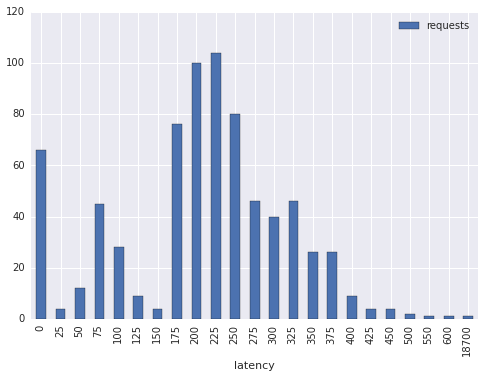

In [3]:
bq.Query(latency_spread).to_dataframe().set_index('latency').plot(kind='bar')

## The Outer Query - Computing Latency Distribution

The second query will build on the first to calculate percentage of requests that each bucket of latency values corresponds to. It will do so by composing a second outer query around the first inner query, and use it as a starting point.

First however, we'll build a query to sum up the total number of requests and capture the result into a local variable.

In [4]:
%%sql --module total_query
SELECT COUNT(latency) AS total
FROM [cloud-datalab:sampledata.requestlogs_20140615]
WHERE endpoint = 'Recent'

In [5]:
total_requests = bq.Query(total_query).results()[0]['total']
print total_requests

734


The outer query can reference both the previously defined query (`latency_spread`) and the scalar value (`total_requests`) using a `$`-prefixed placeholder within the SQL. These placeholders are substituted before the query is processed by BigQuery, either by supplying a dictionary of values as a second argument to `bq.Query`, or if a query is executed directly by a %%sql magic with no `--name` argument, using the variables defined in the notebook.

In [6]:
%%sql --module latency_distribution
SELECT latency,
        requests * 100 / $total_requests AS percentage_requests
FROM $latency_spread
ORDER BY latency

In [7]:
query = bq.Query(latency_distribution, latency_spread=latency_spread, total_requests=total_requests)
df = query.to_dataframe()
df[:10]

,latency,percentage_requests
0,0,8.991826
1,25,0.544959
2,50,1.634877
3,75,6.130790
4,100,3.814714
5,125,1.226158
6,150,0.544959
7,175,10.354223
8,200,13.623978
9,225,14.168937


And here was the full query, as issued to BigQuery (notice literal value and SQL substituted for the placeholders.

In [8]:
print query.sql

SELECT latency,
        requests * 100 / 734 AS percentage_requests
FROM (SELECT INTEGER(latency / 25) * 25 AS latency,
        COUNT(latency) AS requests
FROM [cloud-datalab:sampledata.requestlogs_20140615]
WHERE endpoint = 'Recent'
GROUP BY latency
ORDER BY latency)
ORDER BY latency


# Visualizing the Results

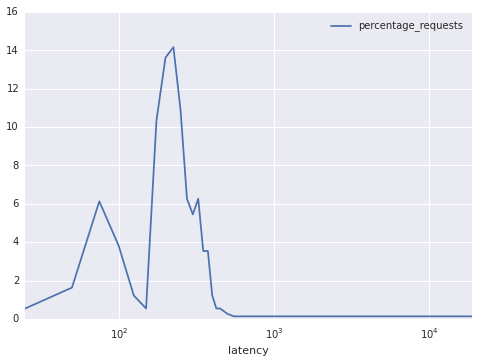

In [9]:
df.set_index('latency').plot(logx = True)